In [1]:
import pickle
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pylab as plt
import os 
import warnings
import seaborn as sns
import random as rn
import matplotlib
import scATAcat


#### define necessary parameters

In [2]:
# set the seed for reproducibility
sd = 1234
np.random.seed(sd)
rn.seed(sd)
%env PYTHONHASHSEED=0


env: PYTHONHASHSEED=0


#### define necessary parameters

In [3]:
warnings.filterwarnings('ignore')

figures_dir = "../../../results/Fig7-Granja_BMMC_scATAC/Fig7-apply_marker_based_annotation/figures/"
data_dir = "../../../results/Fig7-Granja_BMMC_scATAC/"

if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)


In [4]:
def get_common_cells(*dataframes):
    df_cell_list = [v.index for v in dataframes]
    common_cells= list(set.intersection(*map(set,df_cell_list)))
    return(common_cells)

#### define necessary parameters

#### import scanpy object

In [5]:
sc_commonDiffFeatures_adata= pickle.load(open(data_dir +'Fig7-apply_scATAcat/outputs_pairwise/sc_commonDiffFeatures_adata.pkl','rb'))


In [6]:
sc_commonDiffFeatures_adata

AnnData object with n_obs × n_vars = 11333 × 49369
    obs: 'cell_IDs', 'leiden_1.0', 'num_feature_per_cell_'
    var: 'cCREs'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'leiden_1.0_colors'
    obsm: 'num_feature_per_cell', 'X_pca', 'X_umap'
    varm: 'num_cell_per_feature', 'PCs'
    layers: 'binary', 'TF_logIDF'
    obsp: 'distances', 'connectivities'

In [7]:

bmmc_atac_activity_matrix = pd.read_csv(data_dir + "Fig7-apply_seurat_label_transfer/BMMC_atac_gene_activities.csv", index_col=0)


In [8]:
bmmc_atac_activity_matrix.head()

,AAGATAGTCACCGCGA-1,TATGTTCAGGGTTCCC-1,GTTATGGCAACTAGAA-1,GTAGGAGCATTATGGC-1,CCCACATGTCTCGGGT-1,GGAGAACTCCATAGGT-1,CCCTAACAGTCTCTAG-1,GCATTGAAGATGAGGA-1,AGGACGAAGAATCAAC-1,TTATGTCAGGATTGCG-1,...,GCGCATGGTAATGCCT-1,CCCTGATGTCAGTGTT-1,AATGGCTCACAGCCAC-1,TAGCCGGCAGCCACGT-1,CTCAGAAGTACGCAAG-1,TTAGGTGGTGGCCTTG-1,ACCGAATTCTGATCTT-1,GCTTGCTTCGAGGTCC-1,TTGACGAGTTGGGAAC-1,GATGATCCAACTTGGT-1
PLCXD1,5,2,0,0,3,1,0,2,0,2,...,0,0,0,1,0,0,0,1,0,0
GTPBP6,0,1,0,0,3,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
PPP2R3B,0,1,1,2,4,3,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0
SHOX,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
CRLF2,1,7,2,0,2,0,0,1,1,1,...,0,0,1,0,0,0,0,0,0,0


## get the gorund truth cell types

In [9]:
ground_truth_annotations = pd.read_csv("../../../data/Granja2019/BMMC_D6T1/03_cellIDs_and_annotations/metadata.csv")

In [10]:
ground_truth_annotations = ground_truth_annotations[["BioClassification", "Barcode"]]
ground_truth_annotations[['cluster_id', 'annotation']] = ground_truth_annotations['BioClassification'].str.split('_', n=1, expand=True)
ground_truth_annotations.index=ground_truth_annotations['Barcode']
ground_truth_annotations.index.name = None
ground_truth_annotations.columns = ["BioClassification","cell_IDs","cluster_id","annotation"]

In [11]:
ground_truth_renaming_dict={'B':'Bcell',
 'CD14.Mono.1':'Mono',
 'CD14.Mono.2':'Mono',
 'CD4.M':'CD4Tcell',
 'CD4.N1':'CD4Tcell',
 'CD4.N2':'CD4Tcell',
 'CD8.CM':'CD8Tcell',
 'CD8.EM':'CD8Tcell',
 'CD8.N':'CD8Tcell',
 'Early.Baso':'Basofil',
 'GMP':'GMP',
 'HSC':'HSC/MPP',
 'NK':'NKcell',
 'Plasma':'Plasmacell',
 'Unk':'Unknown',
 'cDC':'DC',
 'pDC':'DC',
 'CLP.1': 'CLP',
 'CLP.2': 'CLP',
 'CMP.LMPP': 'CMP/LMPP',
 'Early.Eryth': 'Ery',
 'GMP.Neut': 'GMP',
 'Late.Eryth': 'Ery',
 'Pre.B': 'CLP'}

In [12]:
ground_truth_annotations= ground_truth_annotations.assign(ground_truth_annotations_simplified=list(ground_truth_annotations['annotation'].map(ground_truth_renaming_dict)))
ground_truth_annotations.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
GTGCCAGTCAAGGCAG-1,13_Unk,GTGCCAGTCAAGGCAG-1,13,Unk,Unknown
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono


In [13]:
ground_truth_annotations_known = ground_truth_annotations[ground_truth_annotations['ground_truth_annotations_simplified']!= "Unknown"]

In [14]:
ground_truth_annotations.shape

(12394, 5)

In [15]:
ground_truth_annotations.annotation.value_counts()

annotation
CD14.Mono.1    2077
CD4.N1         1573
CD4.M          1243
GMP            1106
Pre.B           937
CD14.Mono.2     712
Unk             616
CD8.N           570
B               567
CD8.CM          440
GMP.Neut        397
pDC             346
NK              313
Early.Eryth     302
CMP.LMPP        293
Early.Baso      190
CLP.2           165
CLP.1           142
HSC             125
cDC             111
Late.Eryth       74
CD8.EM           42
CD4.N2           30
Plasma           23
Name: count, dtype: int64

In [16]:
ground_truth_annotations.ground_truth_annotations_simplified.value_counts()

ground_truth_annotations_simplified
CD4Tcell      2846
Mono          2789
GMP           1503
CLP           1244
CD8Tcell      1052
Unknown        616
Bcell          567
DC             457
Ery            376
NKcell         313
CMP/LMPP       293
Basofil        190
HSC/MPP        125
Plasmacell      23
Name: count, dtype: int64

In [17]:
ground_truth_annotations_known.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono
GAGCGCTTCTCTTCTC-1,08_GMP.Neut,GAGCGCTTCTCTTCTC-1,08,GMP.Neut,GMP


### get the common cells and subset the pbmc_atac_activity_matrix, as well as the AnnData object to these common cells

In [18]:
common_cells = get_common_cells(sc_commonDiffFeatures_adata.obs, bmmc_atac_activity_matrix.T,ground_truth_annotations_known)

In [19]:
len(common_cells)

10752

In [20]:
sc_commonDiffFeatures_adata =  scATAcat.subset_adata_obs(sc_commonDiffFeatures_adata, obs_list= common_cells, copy_=False)

In [21]:
bmmc_atac_activity_matrix = bmmc_atac_activity_matrix[common_cells]

In [22]:
ground_truth_annotations_known_common = ground_truth_annotations_known.loc[common_cells]

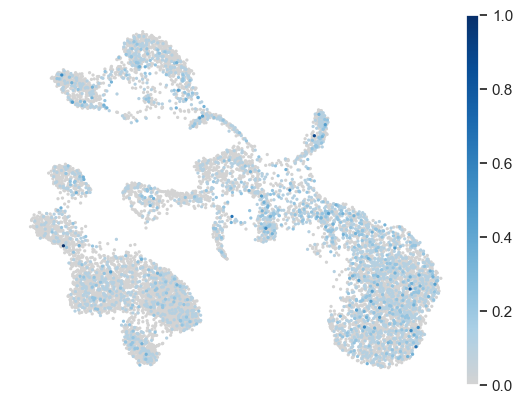

In [23]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name='CD19', 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD19_gene_act_B_marker.pdf",
                           cmap= None)
plt.show()

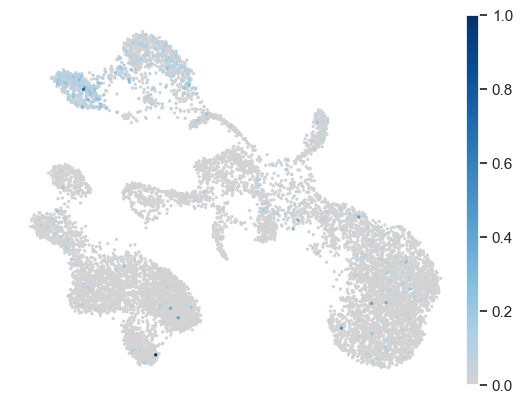

In [24]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="MS4A1", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/MS4A1_gene_act_B_marker.pdf",
                           cmap= None)
plt.show()

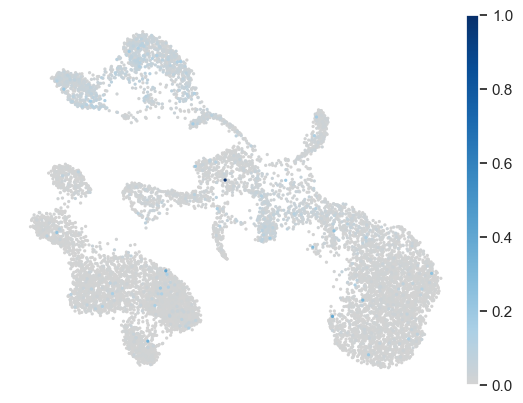

In [25]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="PAX5", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/PAX5_gene_act_B_marker.pdf",
                           cmap= None)
plt.show()

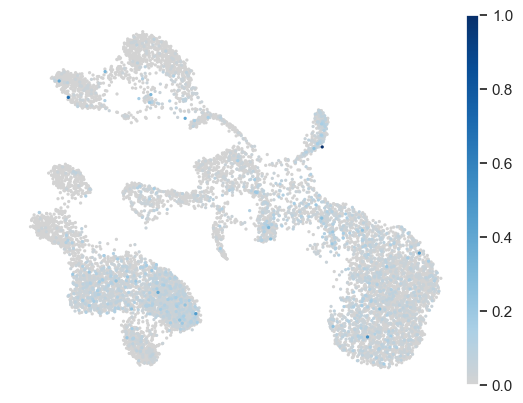

In [26]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD4", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD4_gene_act_CD4T_marker.pdf",
                           cmap= None)
plt.show()

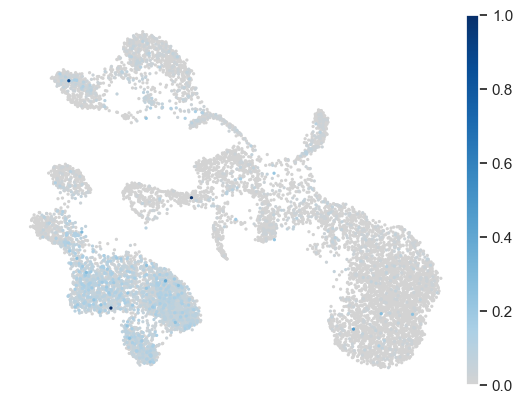

In [27]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="IL7R", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/IL7R_gene_act_CD4T_marker.pdf",
                           cmap= None)
plt.show()

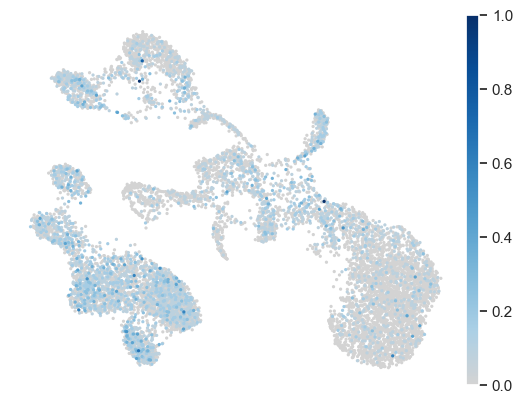

In [28]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CCR7", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CCR7_gene_act_CD4T_marker.pdf",
                           cmap= None)
plt.show()

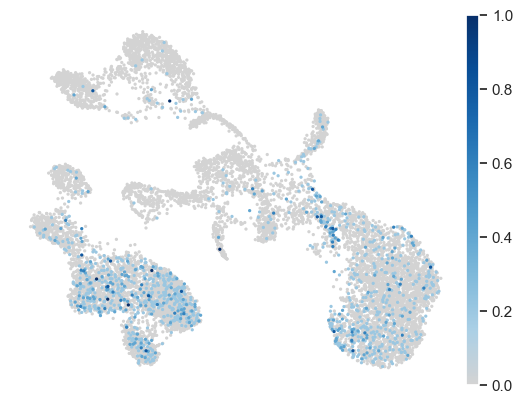

In [29]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CTLA4", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CTLA4_gene_act_CD4T_marker.pdf",
                           cmap= None)
plt.show()

In [30]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="HLA-DR", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/HLA-DR_gene_act_Mono_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


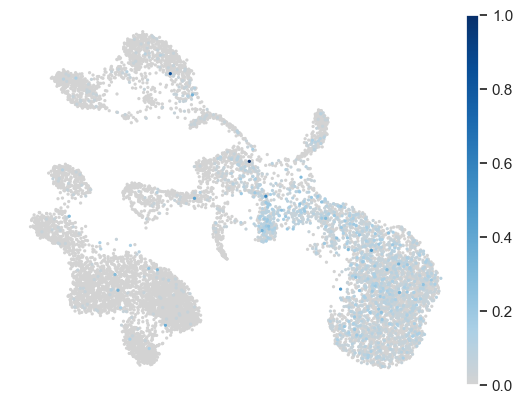

In [31]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="MPO", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/MPO_gene_act_Mono_marker.pdf",
                           cmap= None)
plt.show()

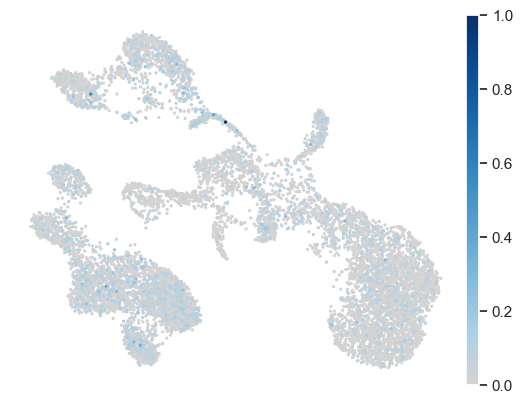

In [32]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD27", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD27_gene_act_B_marker.pdf",
                           cmap= None)
plt.show()

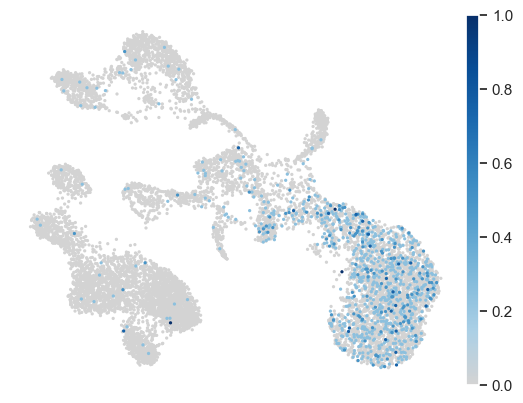

In [33]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="LYZ", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/LYZ_gene_act_Mono_marker.pdf",
                           cmap= None)
plt.show()

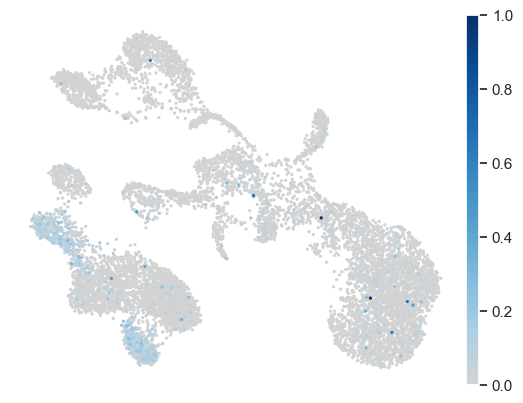

In [34]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD8B", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD8b_gene_act_CD8T_marker.pdf",
                           cmap= None)
plt.show()

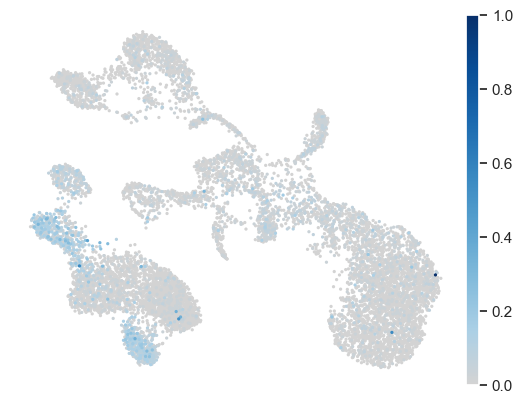

In [35]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD8A", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD8A_gene_act_CD8T_marker.pdf",
                           cmap= None)
plt.show()

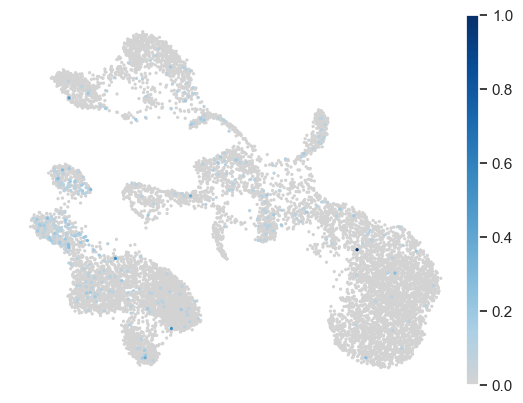

In [36]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="GZMK", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/GZMK_gene_act_CD8T_marker.pdf",
                           cmap= None)
plt.show()

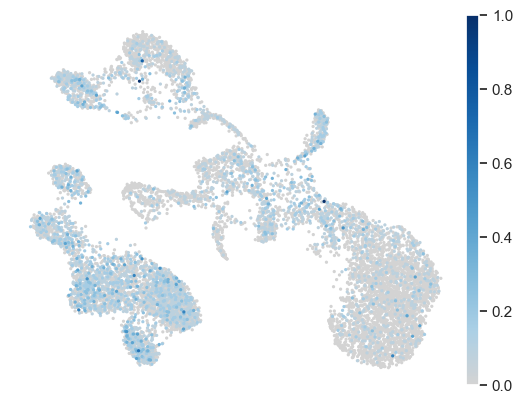

In [37]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CCR7", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CCR7_gene_act_CD8T_marker.pdf",
                           cmap= None)
plt.show()

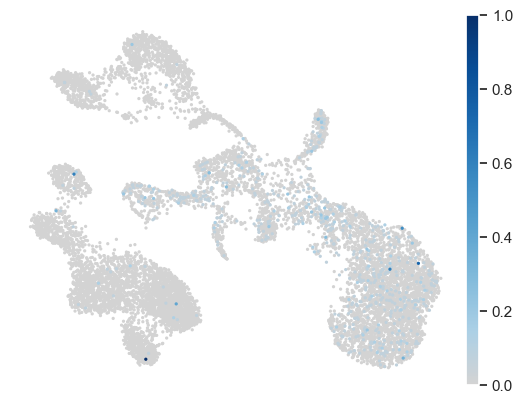

In [38]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="FCER1A", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/FCER1A_gene_act_DC_marker.pdf",
                           cmap= None)
plt.show()

In [39]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD303﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD303_gene_act_DC_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [40]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CD1c﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD1c_gene_act_DC_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [41]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="CLEC9A﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CLEC9A_gene_act_DC_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [42]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="GNLY﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/GNLY_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [43]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿CD56﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD56_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [44]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿CD567", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CD57_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [45]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿CCL3﻿", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/CCL3_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [46]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿FGCR3A", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/FGCR3A_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [47]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿DUSP1", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/DUSP1_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


In [48]:
scATAcat.plot_gene_activity_of_UMAP(adata=sc_commonDiffFeatures_adata, 
                           gene_name="﻿FOS", 
                           activity_matrix=bmmc_atac_activity_matrix,
                           out_path=figures_dir+"/FOS_gene_act_NK_marker.pdf",
                           cmap= None)
plt.show()

this gene is not included in the gene activity matrix


### UMAP embedding colored by ground-truth cell-type identities

In [49]:
ground_truth_annotations_known.head()

,BioClassification,cell_IDs,cluster_id,annotation,ground_truth_annotations_simplified
CACCTGTTCTTTATCG-1,11_CD14.Mono.1,CACCTGTTCTTTATCG-1,11,CD14.Mono.1,Mono
GCCCAGAAGTGTCACT-1,16_Pre.B,GCCCAGAAGTGTCACT-1,16,Pre.B,CLP
CCTTAATCAGTATACC-1,11_CD14.Mono.1,CCTTAATCAGTATACC-1,11,CD14.Mono.1,Mono
TGTGTCCAGAAAGCAG-1,11_CD14.Mono.1,TGTGTCCAGAAAGCAG-1,11,CD14.Mono.1,Mono
GAGCGCTTCTCTTCTC-1,08_GMP.Neut,GAGCGCTTCTCTTCTC-1,08,GMP.Neut,GMP


In [50]:
test_df = sc_commonDiffFeatures_adata.obs

In [51]:
sc_commonDiffFeatures_adata.obs.index.name =None
sc_commonDiffFeatures_adata.obs = pd.merge(test_df, ground_truth_annotations_known_common, on="cell_IDs")

In [52]:
sc_commonDiffFeatures_adata.obs.columns

Index(['cell_IDs', 'leiden_1.0', 'num_feature_per_cell_', 'CD19', 'MS4A1',
       'PAX5', 'CD4', 'IL7R', 'CCR7', 'CTLA4', 'MPO', 'CD27', 'LYZ', 'CD8B',
       'CD8A', 'GZMK', 'FCER1A', 'BioClassification', 'cluster_id',
       'annotation', 'ground_truth_annotations_simplified'],
      dtype='object')

In [53]:
with plt.rc_context():
    sc.pl.umap(sc_commonDiffFeatures_adata, color='ground_truth_annotations_simplified', show=False,size=15 , add_outline=False, frameon=False, title="",palette="tab20")
    plt.savefig(figures_dir + "/UMAP_colored_ground_truth.pdf", bbox_inches="tight")

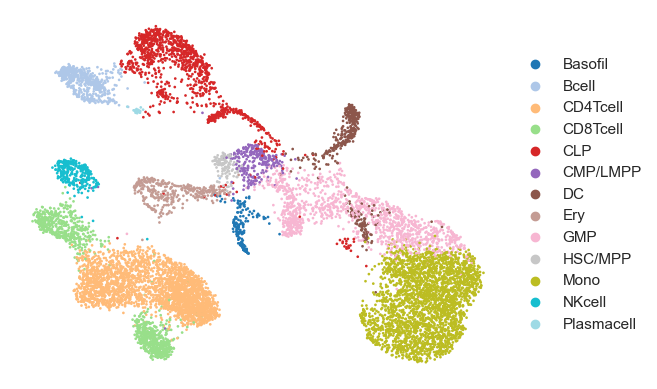

In [54]:
plt.show()

In [55]:
sc_commonDiffFeatures_adata.uns["ground_truth_annotations_simplified_colors"] =['#38184C',  "tab:red", "#82018F","#CA1ED4", "#BDB0D9", "tab:gray", "#275974","#008F8C",'goldenrod','#D46A00',"coral",'#C2EA8C',"#7ED9B7",'goldenrod']

In [56]:
#sc_commonDiffFeatures_adata.uns["ground_truth_annotations_simplified_colors"]= ['#38184C', "#275974", "#82018F",  "#7ED9B7", "#008F8C", "#D46A00",'#F5206A','#97EEF5']

In [57]:
#sc_commonDiffFeatures_adata.uns["ground_truth_annotations_simplified_colors"] =['#38184C', "#275974", "#82018F",  "#7ED9B7", "#008F8C", "#D46A00",'#F5206A','#97EEF5']

In [58]:
sc_commonDiffFeatures_adata.uns.keys()

odict_keys(['pca', 'neighbors', 'umap', 'leiden', 'leiden_1.0_colors', 'ground_truth_annotations_simplified_colors'])

In [59]:
with plt.rc_context():
    
    sc.pl.umap(sc_commonDiffFeatures_adata, color='ground_truth_annotations_simplified', show=False,size=22 , add_outline=False, frameon=False, title="")
    plt.savefig(figures_dir + "/UMAP_colored_ground_truth_matchingcolor.pdf", bbox_inches="tight")

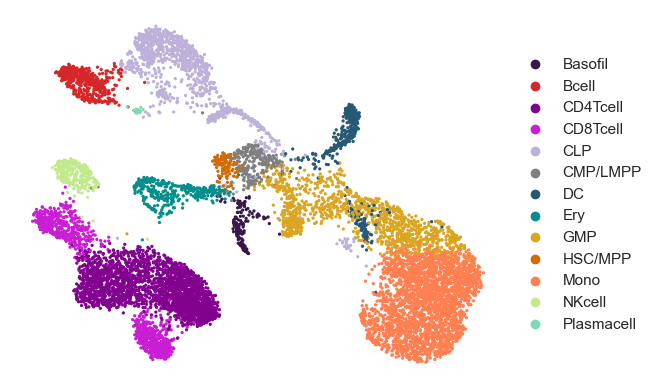

In [60]:
plt.show()

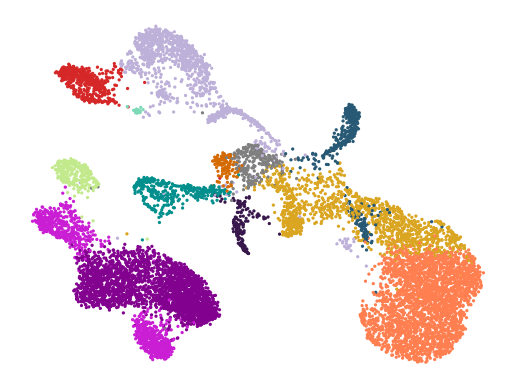

In [61]:
sc.pl.umap(sc_commonDiffFeatures_adata, color='ground_truth_annotations_simplified', show=True,size=22 , add_outline=False, frameon=False, title="",legend_loc="lower center")

In [62]:
len(sc_commonDiffFeatures_adata.uns["ground_truth_annotations_simplified_colors"])

14